# Single-cell analysis and prediction of tumor-infiltrating immune cells
Author: Margaret Paiva

### Dependencies and setting

In [24]:
import numpy as np
import pandas as pd
import scanpy as sc
from collections import OrderedDict
import scintegral.classifier as scint_classifier
import scintegral.utils as scint_utils

In [2]:
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.21.6 scipy==1.8.0 pandas==1.4.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6


### Data

In [3]:
# table with clinical responses
# complete response (CR) and partial response (PR) for responders, 
# stable disease (SD) and progressive disease (PD) for nonresponders
meta = pd.read_csv('data/GSE120575_patient_ID_single_cells.txt.gz', 
                   sep="\t", encoding="latin", 
                   skiprows=19).iloc[:, :7]
# remove additional information after sample table
meta = meta.iloc[:16291]

# rename columns by removing the `characteristics: ` prefix to make it more concise
meta.columns = [x.replace("characteristics: ", "") for x in meta.columns]

# rename the long `patient ID (...)` column to simple sample_id
meta.rename(
    columns={"patinet ID (Pre=baseline; Post= on treatment)": "sample_id"},
    inplace=True
)

# add columns that seperate sample_id for later analysis
meta["patient_id"] = [x.split("_")[1] for x in meta.sample_id]
meta["time_point"] = [x.split("_")[0] for x in meta.sample_id]

meta

,Sample name,title,source name,organism,sample_id,response,therapy,patient_id,time_point
0,Sample 1,A10_P3_M11,Melanoma single cell,Homo sapiens,Pre_P1,Responder,anti-CTLA4,P1,Pre
1,Sample 2,A11_P1_M11,Melanoma single cell,Homo sapiens,Pre_P1,Responder,anti-CTLA4,P1,Pre
2,Sample 3,A11_P3_M11,Melanoma single cell,Homo sapiens,Pre_P1,Responder,anti-CTLA4,P1,Pre
3,Sample 4,A11_P4_M11,Melanoma single cell,Homo sapiens,Pre_P1,Responder,anti-CTLA4,P1,Pre
4,Sample 5,A12_P3_M11,Melanoma single cell,Homo sapiens,Pre_P1,Responder,anti-CTLA4,P1,Pre
...,...,...,...,...,...,...,...,...,...
16286,Sample 16287,H5_P5_M67_L001_T_enriched,Melanoma single cell,Homo sapiens,Post_P6,Non-responder,anti-PD1,P6,Post
16287,Sample 16288,H6_P5_M67_L001_T_enriched,Melanoma single cell,Homo sapiens,Post_P6,Non-responder,anti-PD1,P6,Post
16288,Sample 16289,H7_P5_M67_L001_T_enriched,Melanoma single cell,Homo sapiens,Post_P6,Non-responder,anti-PD1,P6,Post
16289,Sample 16290,H8_P5_M67_L001_T_enriched,Melanoma single cell,Homo sapiens,Post_P6,Non-responder,anti-PD1,P6,Post


In [32]:
# table with sc gene expression
# ge = pd.read_csv('data/GSE120575_Sade_Feldman_melanoma_single_cells_TPM_GEO.txt.gz', 
#                  sep="\t", skiprows=3)

adata = sc.read_text('data/GSE120575_melanoma_scrna_tpm.txt.gz').transpose()
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 16291 × 55737

In [5]:
adata.obs

""
A10_P3_M11
A11_P1_M11
A11_P3_M11
A11_P4_M11
A12_P3_M11
...
H5_P5_M67_L001_T_enriched
H6_P5_M67_L001_T_enriched
H7_P5_M67_L001_T_enriched
H8_P5_M67_L001_T_enriched


In [6]:
adata.var

""
TSPAN6
TNMD
DPM1
SCYL3
C1orf112
...
RP4-621B10.8
RP11-114I8.4
RP11-180C16.1
AP000230.1


In [7]:
adata.X[0:5, 0:10]

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 9.24, 0.  , 0.  , 0.  , 0.  , 0.  , 1.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 7.99, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [8]:
adata.X.shape

(16291, 55737)

In [33]:
adata.obs = adata.obs.merge(meta, 
                            left_index=True, 
                            right_on='title').set_index('title')
adata.obs

,Sample name,source name,organism,sample_id,response,therapy,patient_id,time_point
title,,,,,,,,
A10_P3_M11,Sample 1,Melanoma single cell,Homo sapiens,Pre_P1,Responder,anti-CTLA4,P1,Pre
A11_P1_M11,Sample 2,Melanoma single cell,Homo sapiens,Pre_P1,Responder,anti-CTLA4,P1,Pre
A11_P3_M11,Sample 3,Melanoma single cell,Homo sapiens,Pre_P1,Responder,anti-CTLA4,P1,Pre
A11_P4_M11,Sample 4,Melanoma single cell,Homo sapiens,Pre_P1,Responder,anti-CTLA4,P1,Pre
A12_P3_M11,Sample 5,Melanoma single cell,Homo sapiens,Pre_P1,Responder,anti-CTLA4,P1,Pre
...,...,...,...,...,...,...,...,...
H5_P5_M67_L001_T_enriched,Sample 16287,Melanoma single cell,Homo sapiens,Post_P6,Non-responder,anti-PD1,P6,Post
H6_P5_M67_L001_T_enriched,Sample 16288,Melanoma single cell,Homo sapiens,Post_P6,Non-responder,anti-PD1,P6,Post
H7_P5_M67_L001_T_enriched,Sample 16289,Melanoma single cell,Homo sapiens,Post_P6,Non-responder,anti-PD1,P6,Post


In [9]:
# Get the statistics of the data
# These TPM values; no logarithmizing
mean_expr = pd.Series(adata.X.mean(axis=0))
mean_expr.index = adata.var.index
mean_expr.describe()

count    55737.000000
mean         0.275007
std          0.842511
min          0.000000
25%          0.001366
50%          0.007080
75%          0.105477
max         16.430943
dtype: float64

### Preprocessing

Basic filter:

In [10]:
# Each cell should have a minimum genes expressed;
# Otherwise, they are dropouts
sc.pp.filter_cells(adata, min_genes=200)
# Each genes should be expressed in at least a certain number of cells
# to be considered as an expressed gene
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 16291 × 45884
    obs: 'n_genes'
    var: 'n_cells'

Find and filter genes that are potentially noisy: 

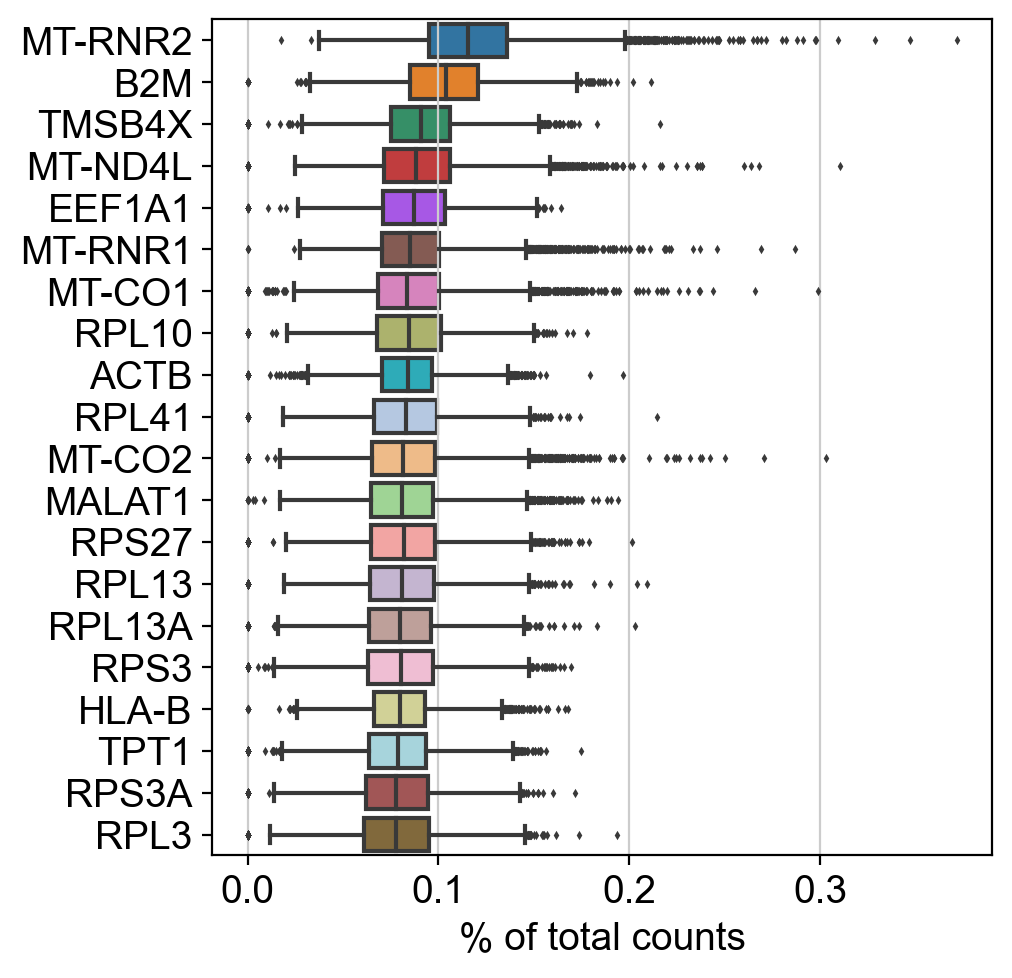

In [11]:
# First, plot genes that yield the highest fraction of counts in each single cell, 
# across all cells
sc.pl.highest_expr_genes(adata, n_top=20, )

In [12]:
# High proportions of mitochondrial genes are indicative of poor-quality cells
# possibly because of loss of cytoplasmic RNA from perforated cells

# annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, 
                           qc_vars=['mt'], 
                           percent_top=None, 
                           log1p=False, 
                           inplace=True)
adata

AnnData object with n_obs × n_vars = 16291 × 45884
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

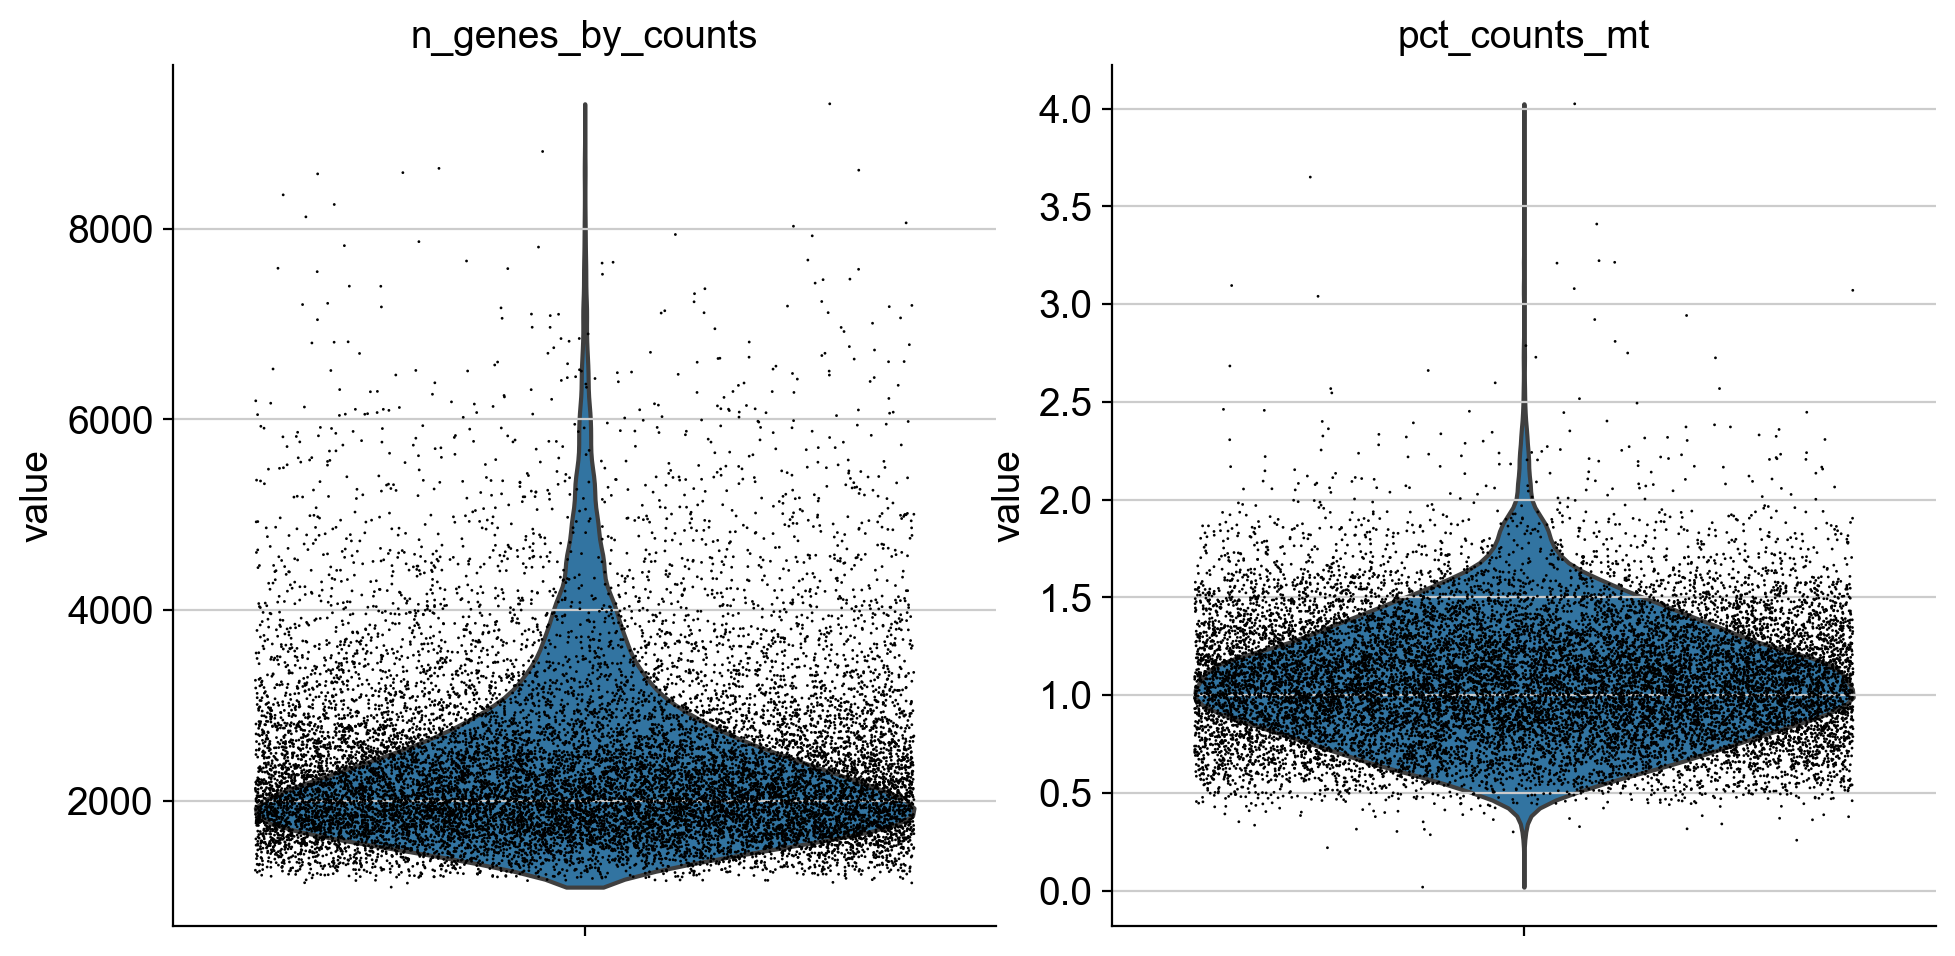

In [13]:
# "n_genes_by_counts" is the genes with various counts expressed in one cell
# too many counts means that that gene could be a noisy geneb 
sc.pl.violin(adata, ['n_genes_by_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [14]:
# filtering noisy genes (samples with too many genes expressed)
adata = adata[adata.obs.n_genes_by_counts < 7000, :]
# filtering samples with too many mitochondrial genes
adata = adata[adata.obs.pct_counts_mt < 2.5, :]
adata

View of AnnData object with n_obs × n_vars = 16215 × 45884
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Automatic cell annotation

scIntegral does not need the data to be normalized. 

In [20]:
marker_dict = {
	'CD4+ T cells':['CD4', 'CXCR3'],
    'CD8+ T cells':['CD8A', 'CD8B'],
    'Regulatory T cells':['FOXP3', 'IL2RA'],
    'Memory T cells':['TCF7', 'LEF1'],
    'Exhausted CD8+ T cells':['PDCD1', 'BTLA'],
    'B cells': ['CD19', 'MS4A1'],
    'Dendritic cells':['ITGAX', 'THBD'],
    'Macrophages':['CD74', 'CD68'] 
}
# "Molecular and cellular insights into T cell exhaustion"
# Whereas senescent CD8+ T cells are often defined by 
# high expression of markers such as KLRG1 and/or CD57, 
# exhausted CD8+ T cells tend to have low expression of these markers. 
# Furthermore, exhausted CD8+ T cells have 
# high expression of PD1, whereas senescent cells do not.

# "PD-1 and BTLA and CD8+ T-cell “exhaustion” in cancer"
# The elevated expression of PD-1, BTLA, 
# and other co-inhibitory molecules on T cells from cancer patients 
# has become an accepted signature for a state called T-cell “exhaustion” 

# 	"Lymphocytes", # 0: TNFAIP3, NR4A2, CREM
#     "Tregs", # 1: CD4, FOXP3
#     "Memory T cells", # 2: TCF7, LEF1
#     "B cells", # 3: CD19, CD79A, MS4A1, CD79B
#     "T cells", #4 : CD3D, CD3E, CD3G
#     "Cytolytic T - Exhausted", # 5: PRF1, CD3D
#     "Cytolytic T", # 6: CD8A, CD3D, PRF1
#     "Cytolytic T / NK cells", # 7: NKG7, CD8A, PRF1
#     "Lymphocytes - 2", # 8
#     "Monocytes", # 9: CD68, LYZ
#     "CD8 T", # 10: CD8A
#     "Cytolytic T - Exhausted - 2", # 11: PRF1, CD3D
#     "Macrophage", # 12: CD68, CD14
#     "Mitochondrial", # 13: MT-genes
#     "B cells - 2", # 14: CD79A
#     "Monocytes - 2", # 15: CD74, TCF4, CTSB
#     "Memory T cells - 2", # 16: TCF7

In [21]:
marker_onehot = scint_utils.marker_input_creator(marker_dict)
marker_onehot

,CD4+ T cells,CD8+ T cells,Regulatory T cells,Memory T cells,Exhausted CD8+ T cells,B cells,Dendritic cells,Macrophages,others
CD4,1,0,0,0,0,0,0,0,0
CXCR3,1,0,0,0,0,0,0,0,0
CD8A,0,1,0,0,0,0,0,0,0
CD8B,0,1,0,0,0,0,0,0,0
FOXP3,0,0,1,0,0,0,0,0,0
IL2RA,0,0,1,0,0,0,0,0,0
TCF7,0,0,0,1,0,0,0,0,0
LEF1,0,0,0,1,0,0,0,0,0
PDCD1,0,0,0,0,1,0,0,0,0
BTLA,0,0,0,0,1,0,0,0,0


In [22]:
bdata = adata[:, marker_onehot.index].copy()
bdata

AnnData object with n_obs × n_vars = 16215 × 16
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [38]:
cov_mat = pd.get_dummies(adata.obs['sample_id'])
cov_mat

,Post_P1,Post_P10,Post_P11,Post_P12,Post_P13,Post_P14,Post_P15,Post_P16,Post_P17,Post_P18,...,Pre_P28,Pre_P29,Pre_P3,Pre_P31,Pre_P33,Pre_P35,Pre_P4,Pre_P6,Pre_P7,Pre_P8
title,,,,,,,,,,,,,,,,,,,,,
A10_P3_M11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A11_P1_M11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A11_P3_M11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A11_P4_M11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A12_P3_M11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H5_P5_M67_L001_T_enriched,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
H6_P5_M67_L001_T_enriched,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
H7_P5_M67_L001_T_enriched,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# A size factor may be defined manually as 
# scaled library size (total UMI count) 
# and should not be placed on the log scale, 
# as the model will do this. 
# The library size should be computed before any gene subsetting
# scIntegral paper used computeSumFactors from R package
lib_size = adata.X.sum(1)
size_factor = lib_size / np.mean(lib_size)
size_factor.shape

(16215,)

In [27]:
pred = scint_classifier.classify_cells(expr_mat=bdata.X,
                                      cov_mat=cov_mat,
                                      size_factor=size_factor,
                                      marker_onehot=marker_onehot)
pred

TypeError: classify_cells() missing 1 required positional argument: 'cov_mat'

In [ ]:
# Automic cell annotation ends
#######################################################

In [ ]:
#######################################################

Skip normalization. The values are already in TPM.

Logarithmize the data:

In [14]:
sc.pp.log1p(adata)
adata

/Users/margaretpaiva/miniconda3/envs/r-env2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 16215 × 45884
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

### Principal component analysis

In [16]:
sc.tl.pca(adata, 
          svd_solver='arpack', 
          n_comps=50)
adata

AnnData object with n_obs × n_vars = 16215 × 45884
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

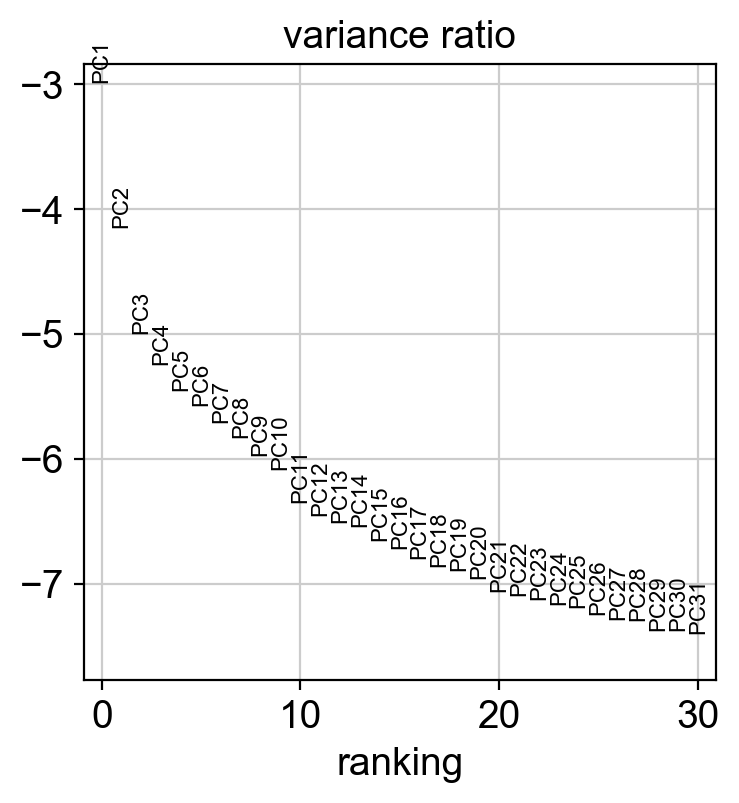

In [17]:
sc.pl.pca_variance_ratio(adata, log=True)

### Computing the neighborhood graph

In [18]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
adata

AnnData object with n_obs × n_vars = 16215 × 45884
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Embedding the neighborhood graph

In [19]:
sc.tl.umap(adata)
adata

AnnData object with n_obs × n_vars = 16215 × 45884
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

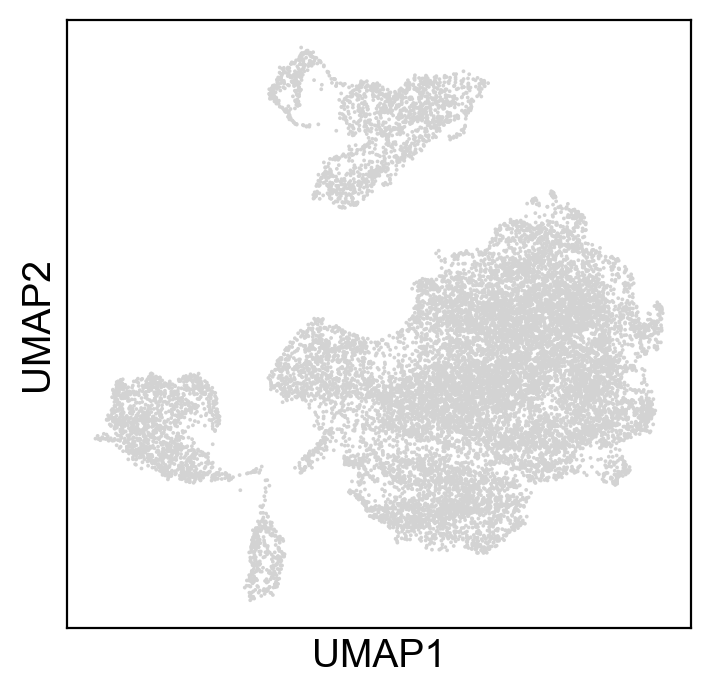

In [20]:
sc.pl.umap(adata)

### Clustering the neighborhood graph

In [21]:
sc.tl.leiden(adata, resolution=0.25)
adata

AnnData object with n_obs × n_vars = 16215 × 45884
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

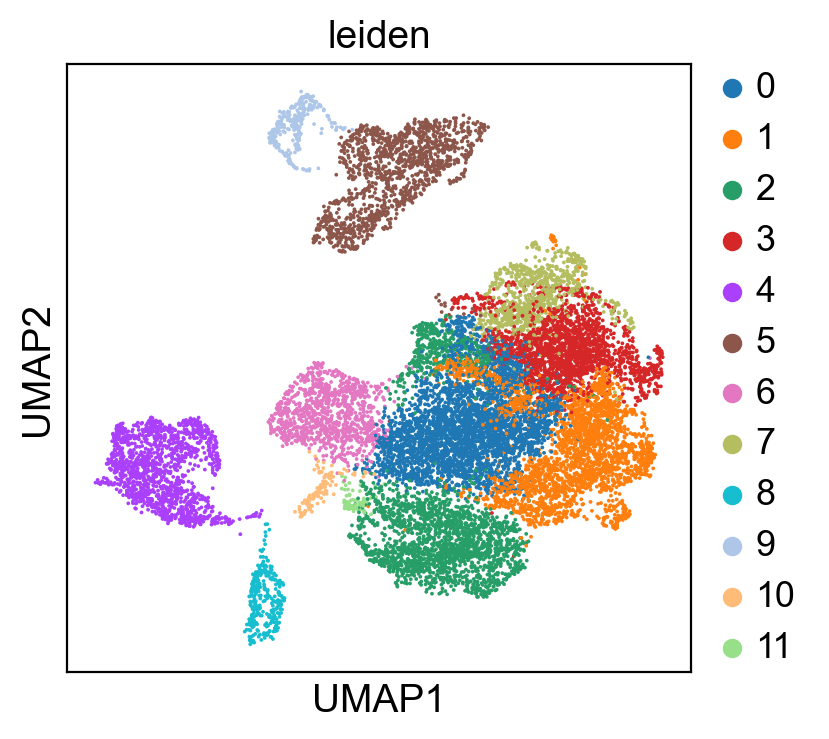

In [22]:
sc.pl.umap(adata, color=['leiden'])

In [23]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

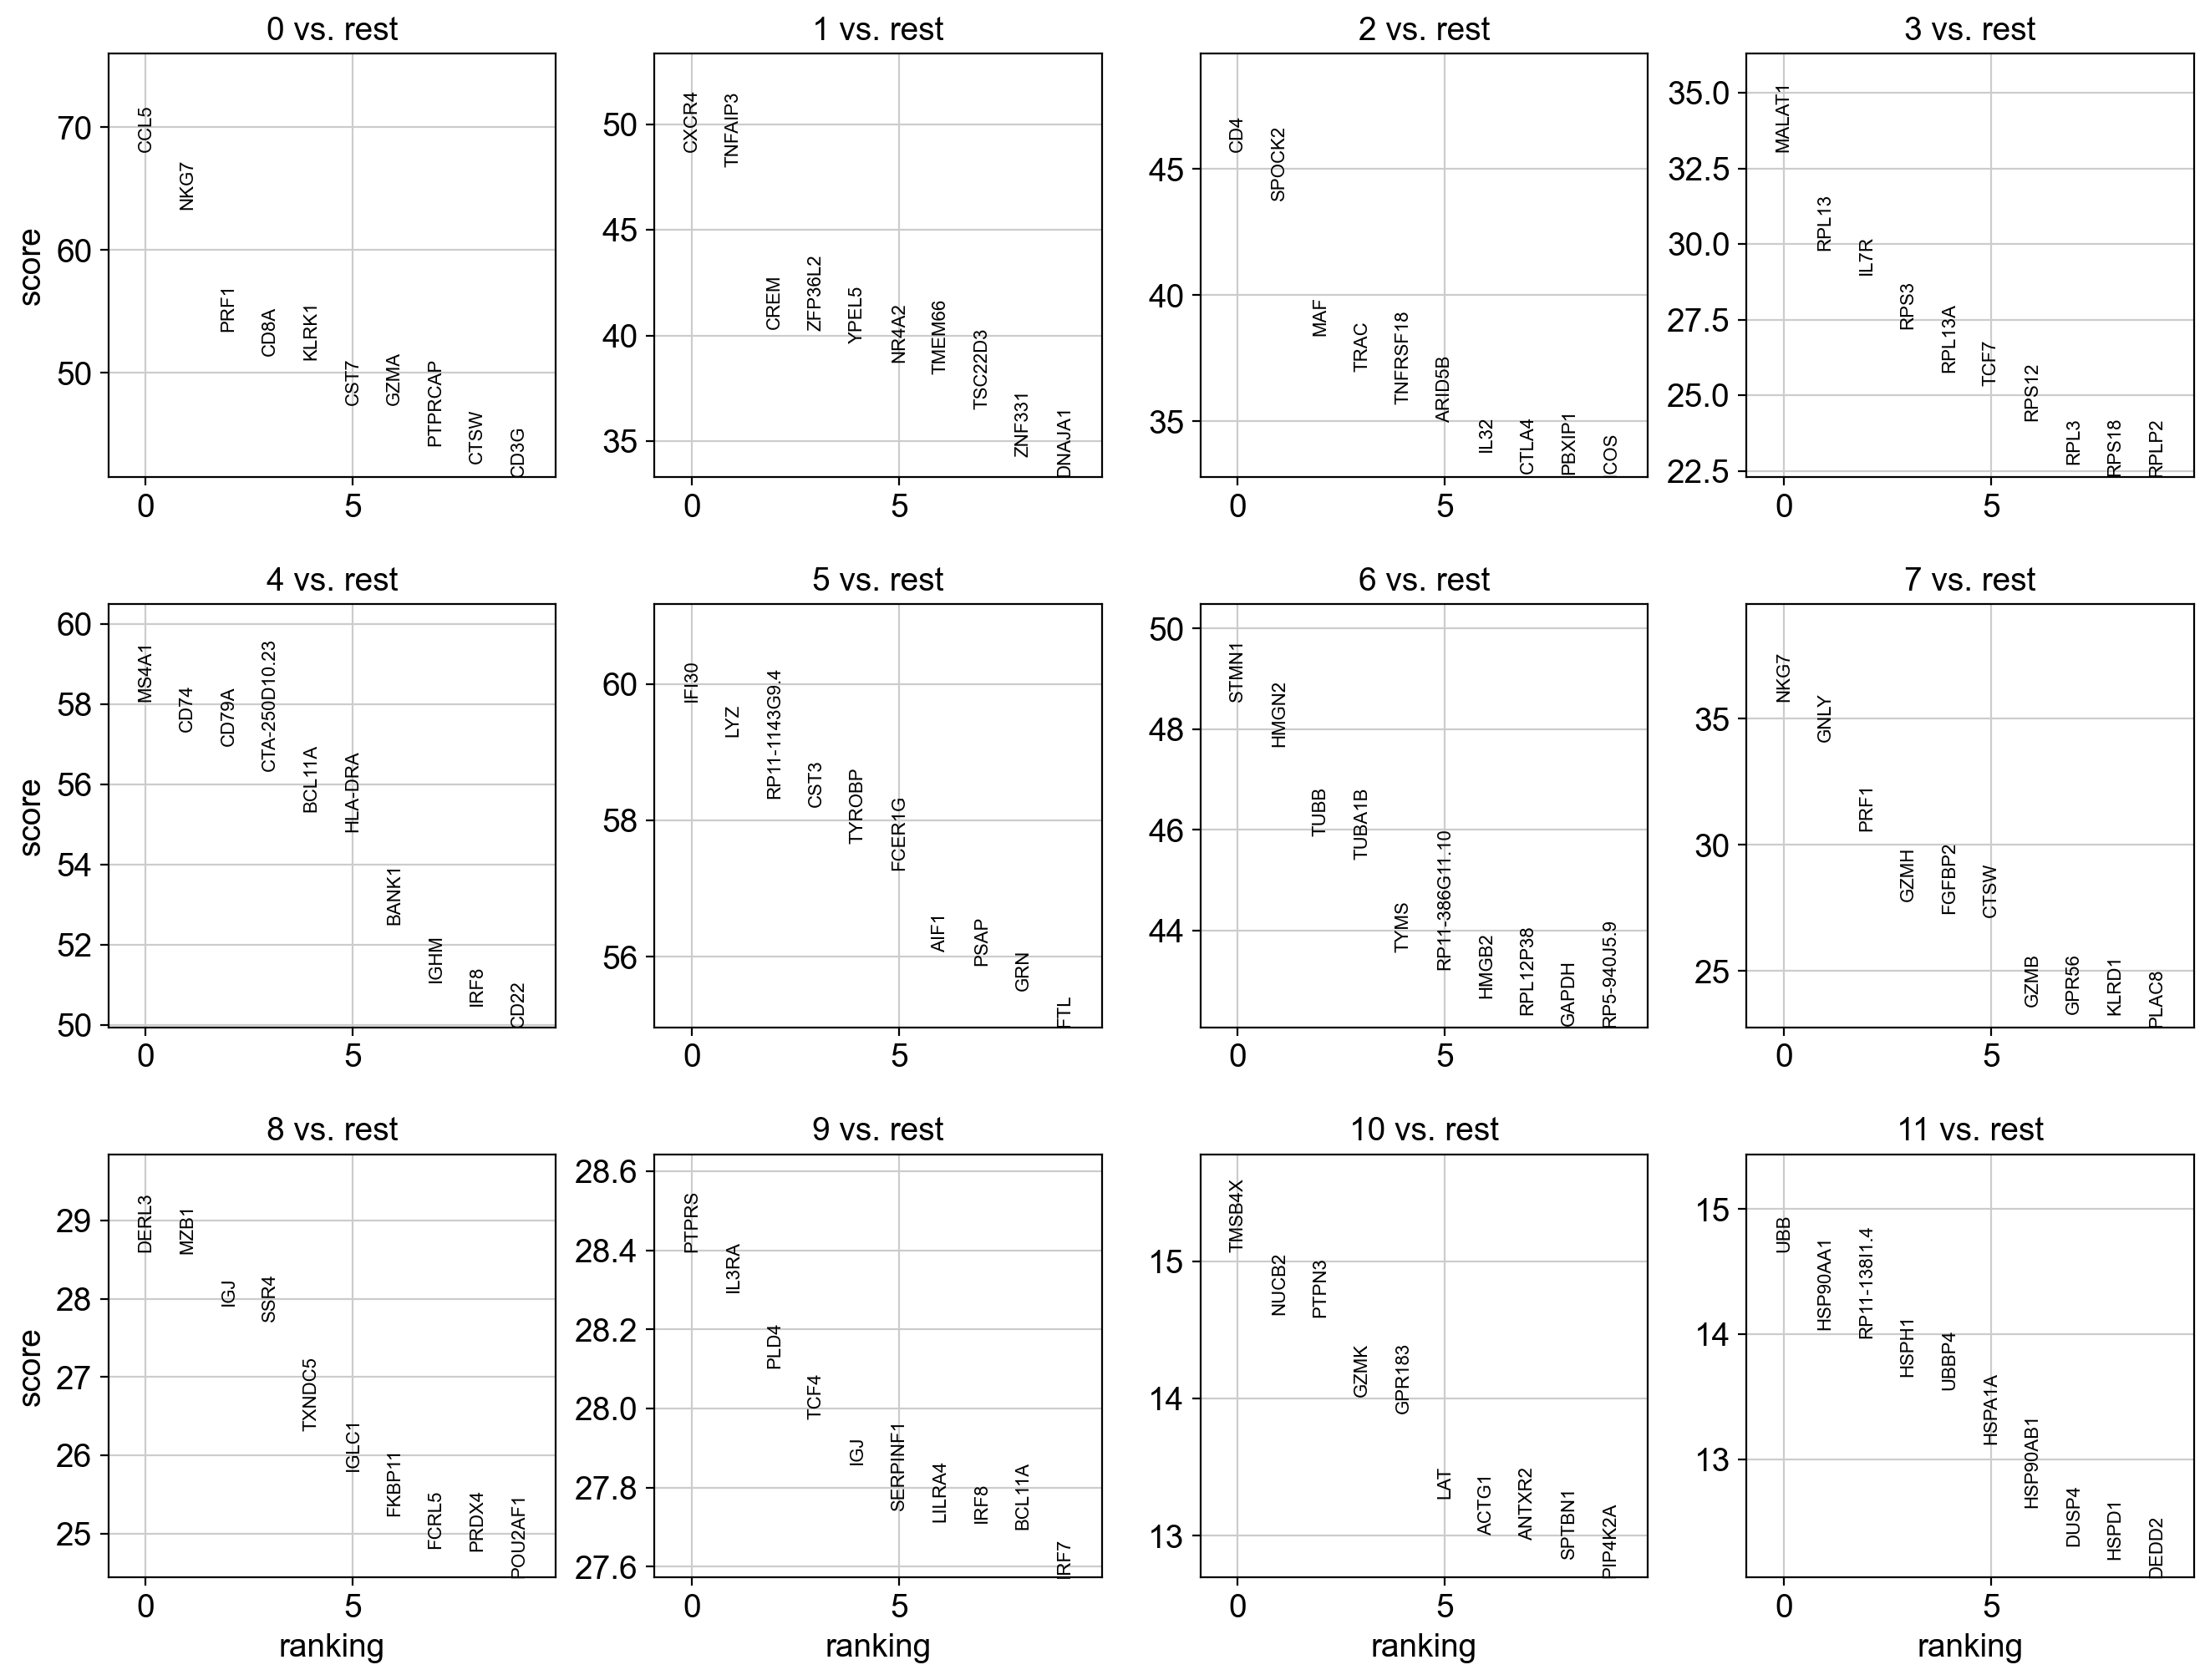

In [24]:
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

In [25]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

,0,1,2,3,4,5,6,7,8,9,10,11
0,CCL5,CXCR4,CD4,MALAT1,MS4A1,IFI30,STMN1,NKG7,DERL3,PTPRS,TMSB4X,UBB
1,NKG7,TNFAIP3,SPOCK2,RPL13,CD74,LYZ,HMGN2,GNLY,MZB1,IL3RA,NUCB2,HSP90AA1
2,PRF1,CREM,MAF,IL7R,CD79A,RP11-1143G9.4,TUBB,PRF1,IGJ,PLD4,PTPN3,RP11-138I1.4
3,CD8A,ZFP36L2,TRAC,RPS3,CTA-250D10.23,CST3,TUBA1B,GZMH,SSR4,TCF4,GZMK,HSPH1
4,KLRK1,YPEL5,TNFRSF18,RPL13A,BCL11A,TYROBP,TYMS,FGFBP2,TXNDC5,IGJ,GPR183,UBBP4
5,CST7,NR4A2,ARID5B,TCF7,HLA-DRA,FCER1G,RP11-386G11.10,CTSW,IGLC1,SERPINF1,LAT,HSPA1A
6,GZMA,TMEM66,IL32,RPS12,BANK1,AIF1,HMGB2,GZMB,FKBP11,LILRA4,ACTG1,HSP90AB1
7,PTPRCAP,TSC22D3,CTLA4,RPL3,IGHM,PSAP,RPL12P38,GPR56,FCRL5,IRF8,ANTXR2,DUSP4
8,CTSW,ZNF331,PBXIP1,RPS18,IRF8,GRN,GAPDH,KLRD1,PRDX4,BCL11A,SPTBN1,HSPD1
9,CD3G,DNAJA1,ICOS,RPLP2,CD22,FTL,RP5-940J5.9,PLAC8,POU2AF1,IRF7,PIP4K2A,DEDD2


- 2 B cell clusters (G1- B cells; G2- plasma cells), 
- 2 myeloid clusters (G3- monocytes and/or macrophages; G4- dendritic cells) 
- 7 clusters enriched for T/NK/NKT cells (G5–11)

In [26]:
# set() removes duplicate; then list() converts back to a list
# marker_genes = list(set(['IGHD', 'CD19', 'CD22', # B-cells
#                          'SDC1', 'IGLV6-57', # Plasma cells
#                          'MARCO', 'CD300E', # Monocytes/Macrophages
#                          'PTCRA', 'CLEC4C', # Dendritic cells
#                          'LMNA', 'IL7R', # Lymphocytes
#                          'CD8A', 'CD8B', # Exhausted CD8+ T-cells
#                          'FOXP3', 'CD4', # Regulatory T-cells
#                          'FGFBP2', 'TGFBR3', # Cytotoxic T-cells
#                          'VCAM1', 'CTLA4', # Exhausted/HS CD8+ T-cells
#                          'LEF1', 'IL7R', # Memory T-cells
#                          'SPC25', 'CDCA5' # Exhausted lymphocytes
# #                 'CD3E', 'CD2', # T cells
# #                 'CD4', 'CD3E', # CD4 T cells
# #                 'CD8A', 'CD8B', # CD8 T cells
# #                 'FOXP3', 'CD3E', 'CTLA4', 'IL2RA' # Regulatory T cells
# #                 'FOXP3', 'CD3E', 'CD4', # Regulatory CD4 T cells
# #                 'FOXP3', 'CD3E', 'CD8A', 'CD8B'# Regulatory CD8 T cells
# #                 'FOXP3', 'CD3E', 'CD4', 'CD8A', 'CD8B'# Regulatory CD4/CD8 T cells
# #                 'CD3E', 'NCR1', 'NCAMa', # NKT cells
# #                 'FCGR3A', # NK cells
# #                 'CD3E', 'CD2', 'CD28' # Activated T cells
#                ]))
marker_genes = list(OrderedDict.fromkeys(['IGHD', 'CD19', 'CD22', # B-cells
                         'SDC1', 'HID1', # Plasma cells
                         'MARCO', 'CD300E', # Monocytes/Macrophages
                         'PTCRA', 'CLEC4C', # Dendritic cells
                         'IL7R', # Lymphocytes
                         'CD8A', 'CD8B', # Exhausted CD8+ T-cells
                         'FOXP3', 'CD4', # Regulatory T-cells
                         'FGFBP2', 'TGFBR3', # Cytotoxic T-cells
                         'VCAM1', 'CTLA4', # Exhausted/HS CD8+ T-cells
                         'LEF1', 'IL7R', # Memory T-cells
                         'SPC25', 'CDCA5' # Exhausted lymphocytes
                                         ]))
marker_genes

['IGHD',
 'CD19',
 'CD22',
 'SDC1',
 'HID1',
 'MARCO',
 'CD300E',
 'PTCRA',
 'CLEC4C',
 'IL7R',
 'CD8A',
 'CD8B',
 'FOXP3',
 'CD4',
 'FGFBP2',
 'TGFBR3',
 'VCAM1',
 'CTLA4',
 'LEF1',
 'SPC25',
 'CDCA5']

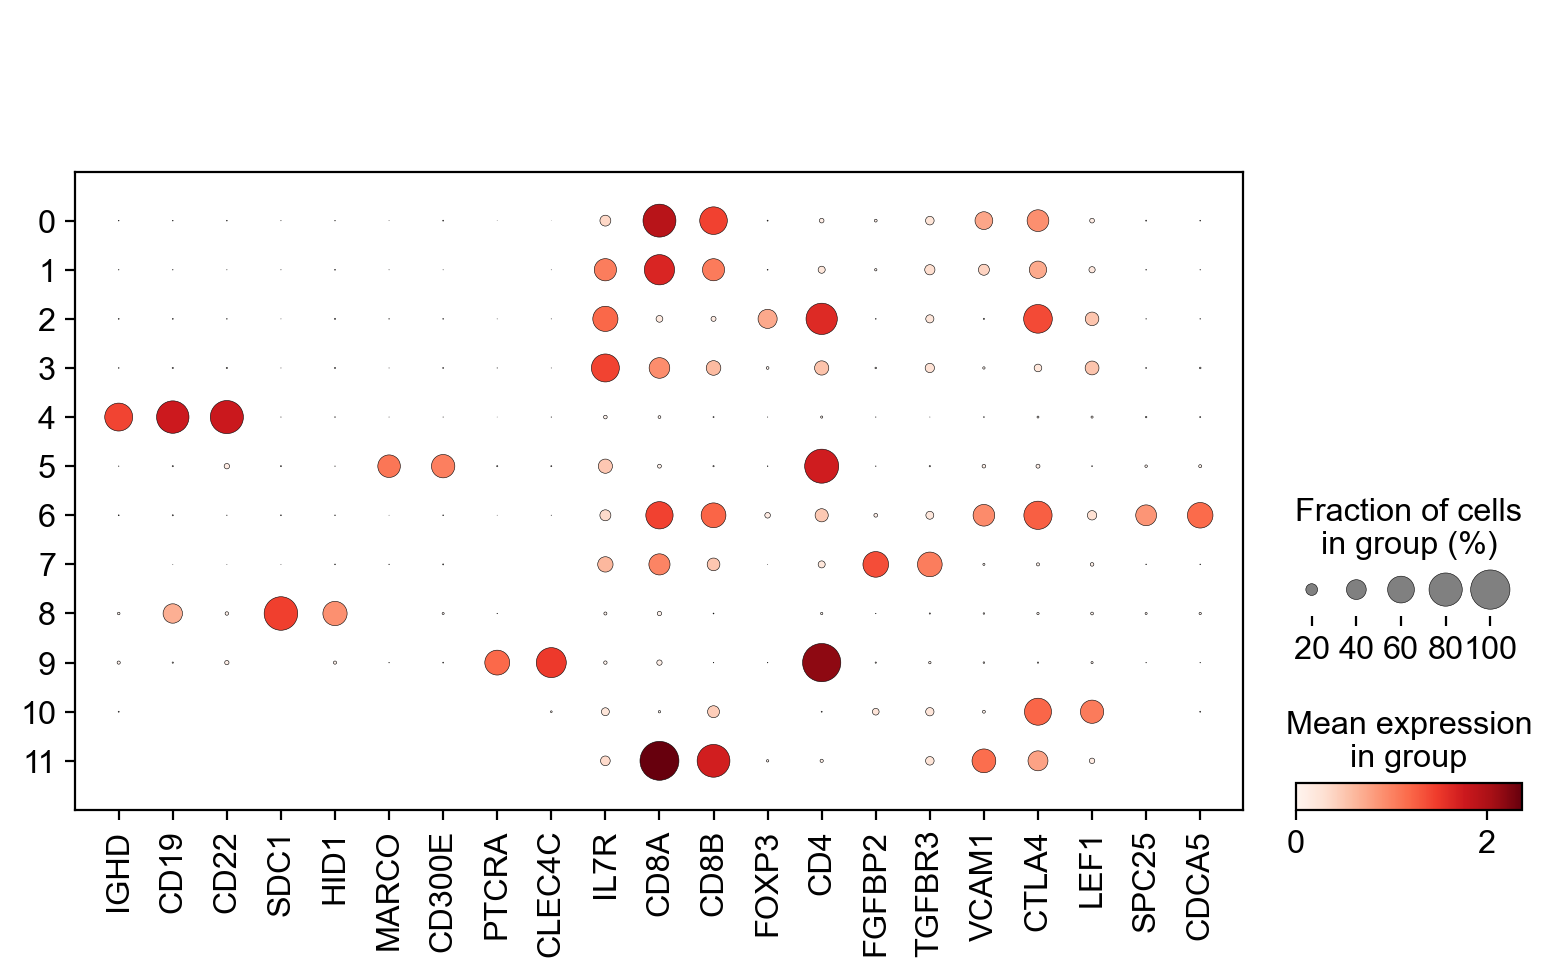

In [27]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden')

00 

01 

02

03 

04 B-cells

05 Monocytes/Macrophages

06

07 Plasma cells

08 Dendritic cells

09

10